<a href="https://colab.research.google.com/github/pumazzo/ML-ISS2025/blob/main/GS/CTGAN_27_11_25_adult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Synthethic Data Generation with CTGAN
- In this notebook, we will train a CTGAN to generate synthetic data from a tabular dataset.
- We will use a CTGAN model from the Synthetic Data Vault (SDV) library: https://docs.sdv.dev/sdv
- We will use the "adult" demo dataset: https://archive.ics.uci.edu/dataset/2/adult included in SDV
- We will evaluate:
1. statistical similarity between synthetic and original dataset;
2. disclosure risk

In [ ]:
!pip install sdv  #Synthetic Data Vault library
!pip install ydata-profiling #libreria per generare report esplorativi automatici sui dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 135.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from sdv.datasets.demo import download_demo,get_available_demos
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer
from sdv.utils import load_synthesizer
from sdmetrics.single_table import privacy, DisclosureProtection,DisclosureProtectionEstimate,DCROverfittingProtection,DCRBaselineProtection

In [ ]:
#Monta Google Drive in Colab per accedere ai file come se fossero in locale.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Lista dei demo dataset disponibili in SDV
get_available_demos(modality='single_table')

,dataset_name,size_MB,num_tables
0,adult,3.91,1
1,alarm,4.52,1
2,asia,1.28,1
3,census,98.17,1
4,census_extended,4.95,1
5,child,3.20,1
6,covtype,255.65,1
7,expedia_hotel_logs,0.20,1
8,fake_companies,0.00,1
9,fake_hotel_guests,0.03,1


In [ ]:
#Carichiamo il dataset "adult"
data, metadata = download_demo(
    modality='single_table',
    dataset_name='adult'
)

# Visualizziamo prime 10 righe del dataset the dataset
data.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,27,Private,177119,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,44,United-States,<=50K
1,27,Private,216481,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K
2,25,Private,256263,Assoc-acdm,12,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
3,46,Private,147640,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,Amer-Indian-Eskimo,Male,0,1902,40,United-States,<=50K
4,45,Private,172822,11th,7,Divorced,Transport-moving,Not-in-family,White,Male,0,2824,76,United-States,>50K
5,29,Private,203697,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,75,United-States,<=50K
6,42,Local-gov,226020,HS-grad,9,Separated,Other-service,Not-in-family,Black,Female,0,0,60,?,<=50K
7,34,Private,120461,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,50,United-States,<=50K
8,60,Local-gov,101110,Assoc-voc,11,Divorced,Prof-specialty,Unmarried,White,Male,0,0,40,United-States,>50K
9,19,Private,102723,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,40,United-States,<=50K


In [ ]:
#Esploriamo il dataset
print(data.columns) #Vediamo i target
data.dtypes #tipi di dato
data.isna().sum() #Controlliamo se ci sono nan

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'label'],
      dtype='object')


,0
age,0
workclass,0
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,0
relationship,0
race,0
sex,0


In [ ]:
# Vediamo i metadata
metadata

{
    "tables": {
        "adult": {
            "columns": {
                "age": {
                    "sdtype": "numerical",
                    "computer_representation": "Int64"
                },
                "workclass": {
                    "sdtype": "categorical"
                },
                "fnlwgt": {
                    "sdtype": "numerical",
                    "computer_representation": "Int64"
                },
                "education": {
                    "sdtype": "categorical"
                },
                "education-num": {
                    "sdtype": "numerical",
                    "computer_representation": "Int64"
                },
                "marital-status": {
                    "sdtype": "categorical"
                },
                "occupation": {
                    "sdtype": "categorical"
                },
                "relationship": {
                    "sdtype": "categorical"
                },
                "rac

In [ ]:
#Rimuoviamo la variabile fnlwgt (non caratteristica dell'individuo ma un peso di campionamento)
data = data.drop(columns=['fnlwgt'])
#aggiorniamo anche i metadata
meta_dict = metadata.to_dict()
del meta_dict['tables']['adult']['columns']['fnlwgt']
metadata = Metadata.load_from_dict(meta_dict)

In [ ]:
metadata.validate()

In [ ]:
#Istanziamo il synthesizer (CTGAN model) settando i parametri di allenamento
synthesizer = CTGANSynthesizer(
    metadata, # required
    generator_dim=(256, 256),
    discriminator_dim=(256, 256),
    generator_lr=2e-4,
    generator_decay=1e-6,
    discriminator_lr=2e-4,
    discriminator_decay=1e-6,
    epochs=300,
    batch_size=500,
    verbose=True
)

In [ ]:
#Train del synthesizer sui dati originali
synthesizer.fit(data)

/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(
Gen. (-0.57) | Discrim. (0.08): 100%|██████████| 300/300 [10:17<00:00,  2.06s/it]


In [ ]:
#Salviamo il synthesizer per poterlo usare in seguito come generatore di dati
synthesizer.save(
    filepath='/content/drive/MyDrive/data_synthesizer_adult.pkl'
)

In [ ]:
#Carichiamo il synthesizer salvato
synthesizer = load_synthesizer(filepath='/content/drive/MyDrive/data_synthesizer_adult.pkl')

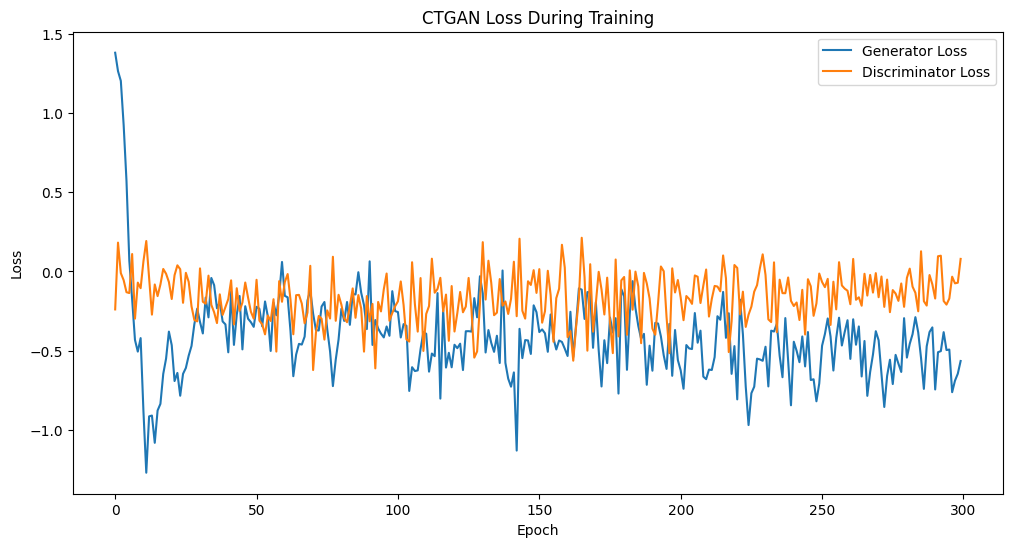

In [ ]:
#Salviamo e visualizziamo la curva di apprendimento
loss_values = synthesizer.get_loss_values() #è un  pandas dataframe
loss_values.to_csv('/content/drive/MyDrive/loss_values_adult.csv',index=False)

df_loss = pd.read_csv('/content/drive/MyDrive/loss_values_adult.csv', index_col='Epoch')


plt.figure(figsize=(12, 6))
plt.plot(df_loss.index, df_loss['Generator Loss'], label='Generator Loss')
plt.plot(df_loss.index, df_loss['Discriminator Loss'], label='Discriminator Loss')

# Labeling
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CTGAN Loss During Training")
plt.legend()
plt.show()

In [ ]:
#Generiamo i dati sintetici
synth_data = synthesizer.sample(num_rows=len(data))

In [ ]:
synth_data

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,29,Private,7th-8th,4,Divorced,Exec-managerial,Not-in-family,Asian-Pac-Islander,Female,5,0,40,Greece,<=50K
1,39,Private,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,7323,1,50,Taiwan,>50K
2,48,Local-gov,Bachelors,13,Married-civ-spouse,Tech-support,Wife,White,Female,3948,0,40,United-States,<=50K
3,44,Private,HS-grad,9,Widowed,?,Own-child,White,Female,3582,0,7,United-States,<=50K
4,30,Federal-gov,Some-college,10,Never-married,Adm-clerical,Wife,Black,Female,3688,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,34,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,<=50K
32557,47,Private,Bachelors,13,Married-civ-spouse,Other-service,Husband,White,Male,7470,0,49,United-States,>50K
32558,41,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,3570,1,46,Vietnam,<=50K
32559,26,Private,5th-6th,4,Married-civ-spouse,Other-service,Other-relative,Asian-Pac-Islander,Male,2646,1,40,China,<=50K


In [ ]:
#Salviamo i dati sintetici generati
synth_data.to_csv('/content/drive/MyDrive/dati_sintetici_adult.csv',index=False)

In [ ]:
#Carichiamo il dataset sintetico salvato
synth_data = pd.read_csv('/content/drive/MyDrive/dati_sintetici_adult.csv')

In [ ]:
synth_data

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,29,Private,7th-8th,4,Divorced,Exec-managerial,Not-in-family,Asian-Pac-Islander,Female,5,0,40,Greece,<=50K
1,39,Private,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,7323,1,50,Taiwan,>50K
2,48,Local-gov,Bachelors,13,Married-civ-spouse,Tech-support,Wife,White,Female,3948,0,40,United-States,<=50K
3,44,Private,HS-grad,9,Widowed,?,Own-child,White,Female,3582,0,7,United-States,<=50K
4,30,Federal-gov,Some-college,10,Never-married,Adm-clerical,Wife,Black,Female,3688,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,34,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,<=50K
32557,47,Private,Bachelors,13,Married-civ-spouse,Other-service,Husband,White,Male,7470,0,49,United-States,>50K
32558,41,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,3570,1,46,Vietnam,<=50K
32559,26,Private,5th-6th,4,Married-civ-spouse,Other-service,Other-relative,Asian-Pac-Islander,Male,2646,1,40,China,<=50K


In [ ]:
#Run diagnostic to ensure that the data is valid (same categorial variables, column names, continuous values range,unique IDs)
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality, get_column_plot,get_column_pair_plot

diagnostic_report = run_diagnostic(
    real_data=data,
    synthetic_data=synth_data,
    metadata=metadata
)


Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 202.00it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 307.95it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [ ]:
diagnostic_report.get_details(property_name='Data Validity')

,Column,Metric,Score
0,age,BoundaryAdherence,1.0
1,workclass,CategoryAdherence,1.0
2,education,CategoryAdherence,1.0
3,education-num,BoundaryAdherence,1.0
4,marital-status,CategoryAdherence,1.0
5,occupation,CategoryAdherence,1.0
6,relationship,CategoryAdherence,1.0
7,race,CategoryAdherence,1.0
8,sex,CategoryAdherence,1.0
9,capital-gain,BoundaryAdherence,1.0


In [ ]:
diagnostic_report.get_details(property_name='Data Structure')

,Metric,Score
0,TableStructure,1.0


In [ ]:
#statistics
from ydata_profiling  import ProfileReport
import webbrowser

profile = ProfileReport(
    data, title="Profiling Real Data", html={"style": {"full_width": True}}
)
profile.to_file("real_data_report_ctgan_adult.html")

profile_synthetic= ProfileReport(
    synth_data, title="Profiling Synthetic Data", html={"style": {"full_width": True}}
)
profile_synthetic.to_file("synth_data_report_ctgan_adult.html")

from google.colab import files
files.download("real_data_report_ctgan_adult.html")
files.download("synth_data_report_ctgan_adult.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 18.62it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 21.55it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data Quality metrics (statistical similarity)

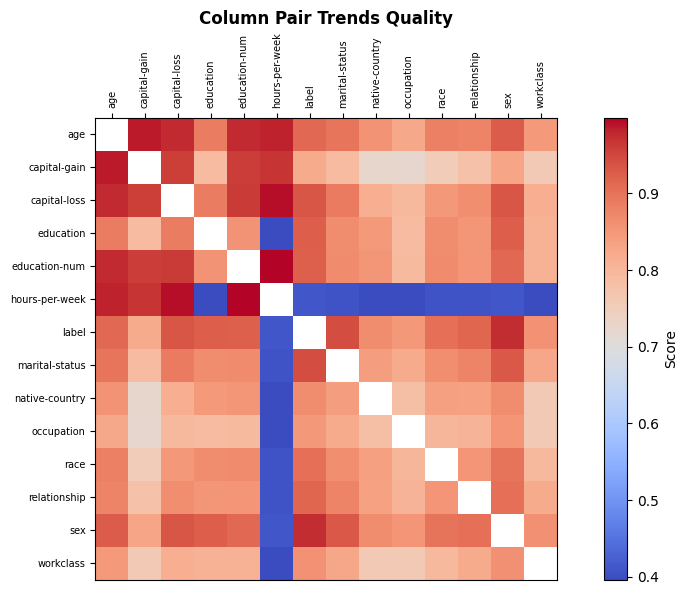

In [ ]:
quality_report = evaluate_quality(
    real_data=data,
    synthetic_data=synth_data,
    metadata=metadata
)

#***************************************************************
# column_shapes= The statistical similarity for single columns of data;
# calcola la divergenza statistica( KS Statistic per numerical o TV distance categorical)

col_shapes= quality_report.get_details('Column Shapes')
col_shapes=col_shapes.sort_values(by='Score',ascending=False)

plt.figure(figsize=(12,6))
plt.bar(col_shapes['Column'],col_shapes['Score'], color='skyblue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Column",fontweight='bold')
plt.ylabel("Score",fontweight='bold')
plt.title("Column Shapes Quality",fontweight='bold')
plt.xticks(rotation=90)
plt.show()

#****************************************************************
# column pair trends= The statistical similarity for pairs of columns,
# often called the correlation or bivariate distributions of the columns

col_pair=quality_report.get_details('Column Pair Trends')

pivot_table = col_pair.pivot(index='Column 1', columns='Column 2', values='Score')
all_cols = sorted(set(pivot_table.index) | set(pivot_table.columns))  #
pivot_table = pivot_table.reindex(index=all_cols, columns=all_cols)
pivot_table = pivot_table.combine_first(pivot_table.T)

matrix = pivot_table.values
row_labels = pivot_table.index.tolist()
col_labels = pivot_table.columns.tolist()

fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.matshow(matrix, cmap='coolwarm')
fig.colorbar(cax, label='Score')
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels, fontsize=7, rotation=90)
ax.set_yticklabels(row_labels,fontsize=7)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.title('Column Pair Trends Quality',fontweight='bold')
plt.show()

In [ ]:
# Visualizzazione delle distribuzioni univariate
variable='education-num'
fig = get_column_plot(
    real_data=data,
    synthetic_data=synth_data,
    column_name=variable,
    metadata=metadata
)
fig.show()

In [ ]:
# Visualizzazione delle distribuzioni bivariate
variables=['age', 'race']

fig =get_column_pair_plot(
real_data=data,
synthetic_data=synth_data,
column_names=variables,
metadata=metadata,
)
fig.show()

# Privacy metrics



*   Identity disclosure: identificare un individuo specifico nel dataset conoscendo i suoi quasi-identificatori




In [ ]:
#K-ANONyMITY: ogni combinazione di QI compare almeno k volte nel dataset; ogni persona è indistinguibile
#da almeno altre k-1 persone con gli stessi QI; più è alto -> minore rischio di re-identificazione
#Serve a capire la vulnerabilità del dataset originale

def k_anonymity(df, quasi_identifiers):
    # Raggruppa le righe in base ai QI e conta le occorrenze
    equivalence_groups = df.groupby(quasi_identifiers).size().reset_index(name='k_count')
    # Numero totale di gruppi di equivalenza
    num_groups = len(equivalence_groups)
    # Calcola il minimo numero di occorrenze (la dimensione del gruppo più piccola)
    min_k = equivalence_groups['k_count'].min()

    print(f"Numero totale di gruppi di equivalenza: {num_groups}")
    print(f"Livello Minimo di k-Anonimità (k_min): {min_k}")
    print(f"Il dataset è {min_k}-anonimo.")

    return equivalence_groups

In [ ]:
groups_real=k_anonymity(data, ['sex','age','native-country'])
groups_real.sort_values('k_count')
anonim_1= len(groups_real[groups_real['k_count']==1])
print(f'Numero di record con 1-anonimity: {anonim_1}')

Numero totale di gruppi di equivalenza: 1750
Livello Minimo di k-Anonimità (k_min): 1
Il dataset è 1-anonimo.
Numero di record con 1-anonimity: 977


In [ ]:
# Misura la percentuale di record che risultano "unici" nel dataset originale rispetto ai QI
# - alta  → rischio elevato di reidentificazione

def unique_in_original(df, quasi_identifiers):
  equivalence_size = df.groupby(quasi_identifiers).size() #numerosità dei gruppi di equivalenza
  unique_records= equivalence_size[equivalence_size == 1] #vedo le combinazioni uniche di QI
  num_uniques=unique_records.sum()
  uio= (num_uniques / len(df)) * 100
  print(f"La misura Unique in Original è: {uio:.2f}%")
  return equivalence_size

In [ ]:
equivalence_size=unique_in_original(data, ['age','sex','native-country'])

La misura Unique in Original è: 3.00%


In [ ]:
# Misura la percentuale di record che risultano "unici" nel dataset rispetto ai QI
#sia nel dataset originale, che in quello sintetico
# - alta  → rischio elevato di replicazione di soggetti specifici nel sintetico
# limite superiore è unique in original

def replicated_uniques(df, df_synth, quasi_identifiers):
  # Raggruppa l'originale per QI e conta le occorrenze k; vedo quelle uniche
  equivalence_size = df.groupby(quasi_identifiers).size().reset_index(name='k_originale')
  unique_records= equivalence_size[equivalence_size['k_originale'] == 1]

  # Se non ci sono record unici nell'originale, il rischio è 0
  if unique_records.empty:
    return 0.0

  # Raggruppa il sintetico per QI e conta le occorrenze k; vedo quelle uniche
  synthetic_counts = df_synth.groupby(quasi_identifiers).size().reset_index(name='k_sintetico')
  synthetic_uniques = synthetic_counts[synthetic_counts['k_sintetico'] == 1]

  # Fai l'intersezione tra le combinazioni uniche originali e le combinazioni uniche sintetiche
  # L'oggetto 'merged' conterrà solo le righe che sono uniche in ENTRAMBI i dataset
  merged = pd.merge(
      unique_records,
      synthetic_uniques,
      on=quasi_identifiers,
      how='inner' # Mantiene solo le intersezioni
  )

  # Numero di unici replicati
  num_replicated_uniques = len(merged)

  # Calcolo della percentuale replicated_uniques
  repu_percent = (num_replicated_uniques / len(df)) * 100

  print(f"Il RepU è: {repu_percent:.2f}%")
  return repu_percent

In [ ]:
repu=replicated_uniques(data,synth_data,  ['age','sex','native-country'])

Il RepU è: 0.70%


*   Attribute disclosure: pur non riuscendo a risalire all'identità di una persona, riesco a dedurre un valore sensibile utilizzando i suoi QI


In [ ]:
#L-DIVERSITY: in ogni gruppo definito dai QI ci sono almeno L valori diversi dell’attributo sensibile.
# più è alto → più è difficile indovinare il valore sensibile

def l_diversity(df, quasi_identifiers, sensitive_attr):
    # Raggruppa per quasi-identificatori
    equivalence_groups = df.groupby(quasi_identifiers)
    # Conta il numero di valori distinti dell'attributo sensibile per ogni gruppo
    diversity= equivalence_groups[sensitive_attr].nunique().reset_index(name='l_diversity_count')
    # Calcola il minimo numero di valori distinti nei gruppi
    L = diversity['l_diversity_count'].min()
    print(f"Livello Minimo di l-Diversità: {L}")
    return diversity

In [ ]:
div_real=l_diversity(data, ['sex','age','native-country'],'marital-status')
div_real.sort_values('l_diversity_count')
div_1= len(div_real[div_real['l_diversity_count']==1])
print(f'Numero di gruppi di equivalenza con 1-diversity: {div_1}')

Livello Minimo di l-Diversità: 1
Numero di gruppi di equivalenza con 1-diversity: 1218


In [ ]:
# "Practical privacy metrics for synthetic data", Gillian M Raab et al.,2025, arXiv:2406.16826v3
#https://doi.org/10.48550/arXiv.2406.16826

# Misura la percentuale di record del dataset reale per cui l'attributo sensibile
# è perfettamente prevedibile usando i quasi-identificatori (QI) in quanto associato a un solo valore del target

# più è alta → target è facilmente prevedibile; si calcola per ogni attributo sensibile

def disclosive_in_original(df, quasi_identifiers):

  #seleziona target sensibili
  targets = [col for col in df.columns if col not in quasi_identifiers]

  categorical_targets = [
    col for col in targets
    if df[col].dtype == 'object'] #nb solo per i categorici!

  risultati = {}
  total_records = len(df)

  for t in categorical_targets:
    #raggruppo per QI e conto i valori unici del target,assegnando questo conto a ogni record
    l_diversity = df.groupby(quasi_identifiers)[t].transform('nunique')
    #conto i record in questi gruppi che soddisfano la condizione un solo valore di target
    disclosive_records = (l_diversity == 1).sum()

    #calcolo come percentuale sui dati originali
    dorig=(disclosive_records/len(df))*100
    risultati[t] = dorig

  for target, dorig in risultati.items():
      print(f"Target '{target}': {dorig:.2f}%")


In [ ]:
disclosive_in_original(data,  ['age','sex','native-country'])

Target 'workclass': 5.50%
Target 'education': 3.49%
Target 'marital-status': 4.84%
Target 'occupation': 3.35%
Target 'relationship': 4.42%
Target 'race': 7.01%
Target 'label': 13.08%


In [ ]:
## Misura la percentuale di record del dataset reale per cui, nel dataset sintetico, esiste una combinazione degli stessi QI che identifica
#un solo valore del target considerato e questo coincide con quello effettivo del record reale.

# più è alta → più il dataset sintetico è in grado di inferire correttamente valori sensibili
#limite superiore è disclosive_in_original

def disclosive_in_synthetic_and_correct(df, df_synth, quasi_identifiers):

  #seleziona target sensibili
  targets = [col for col in df.columns if col not in quasi_identifiers]

  categorical_targets = [
    col for col in targets
    if df[col].dtype == 'object'] #nb solo per i categorici!

  risultati = {}
  total_records = len(df)

  for t in categorical_targets:
     # Per ogni record sintetico, calcola quanti valori diversi del target esistono nel suo gruppo QI
    l_synth = df_synth.groupby(quasi_identifiers)[t].transform('nunique')
    #seleziono le righe che hanno target unico
    unique_synth = df_synth[l_synth == 1]

    #Estrai SOLO UNA riga per ogni combinazione QI + target nel sintetico, altrimenti ho duplicati nel merge (vedi dopo)
    unique_synth_clean = unique_synth[quasi_identifiers + [t]].drop_duplicates()


    # Se nel sintetico NON ci sono record che soddisfano questa condizione il rischio è zero
    if unique_synth_clean.empty:
        risultati[t] = 0.0
        continue

    #confronta con l’ORIGINALE: tutte le righe che hanno esattamente quei QI e quel valore t
    merged = df.merge(
        unique_synth_clean,
        on=quasi_identifiers + [t],
        how='inner'
    )

    #corrispondenze trovate nell'originale, calcolato come percentuale
    disco_count = len(merged)
    risultati[t] = (disco_count / total_records) * 100

  for target, value in risultati.items():
      print(f"Target '{target}': {value:.2f}%")

In [ ]:
disclosive_in_synthetic_and_correct(data, synth_data, ['age','sex','native-country'])

Target 'workclass': 2.55%
Target 'education': 0.26%
Target 'marital-status': 1.98%
Target 'occupation': 0.32%
Target 'relationship': 1.36%
Target 'race': 3.07%
Target 'label': 6.75%


In [ ]:
#ALTRE METRICHE DI SDV
#https://docs.sdv.dev/sdmetrics/data-metrics/privacy

# - DisclosureProtection:pretend the attacker knows a few columns of the real data
# (known columns) and wants to guess other columns (sensitive columns). Also has a full synthetic dataset.
# It describes how much your synthetic data protects against the risk of disclosure as compared to a baseline of completely random data.
# best -> 1
#use DisclosureProtectionEstimate if dataser too large

#implementa una metrica basata su CAP: probabilità che un attaccante, osservando il sintetico, sia in grado di indovinare il valore sensibile
#1.simula attacchi predittivi su record reali usando il sintetico
#2.misura quanto spesso l’attacco fallisce (protezione)
3#.confronta con la protezione del caso random

#NB: 1-CAP è una disclosure PROBABILISTICA!
#DISCO è più conservativa e deterministica(vede solo i casi peggiori, dove il rischio di identificazione del target è del 100%)

score_disclosure = DisclosureProtectionEstimate.compute_breakdown(
    real_data=data,
    synthetic_data=synth_data,
    known_column_names=['age','sex','native-country'],
    sensitive_column_names=['race'],
    num_rows_subsample=1000
)

#- DCRBaselineProtection: distance between your synthetic data and real data;
# it compares the distance against randomly generated data, which would provide the best possible privacy protection.
metadata_dict=metadata.to_dict()
metadata_table=metadata_dict['tables']['adult']
score_distance=DCRBaselineProtection.compute_breakdown(
    real_data=data,
    synthetic_data=synth_data,
    metadata=metadata_table,
    num_rows_subsample=500,
    num_iterations=10
)

Estimating Disclosure Protection (Score=0.305): 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


In [ ]:
score_disclosure

{'score': 0.30518692377973,
 'cap_protection': 0.244149539023784,
 'baseline_protection': 0.8}

In [ ]:
score_distance

{'score': 0.20646801888170047,
 'median_DCR_to_real_data': {'synthetic_data': 0.08934535856063826,
  'random_data_baseline': 0.4328633040802585}}